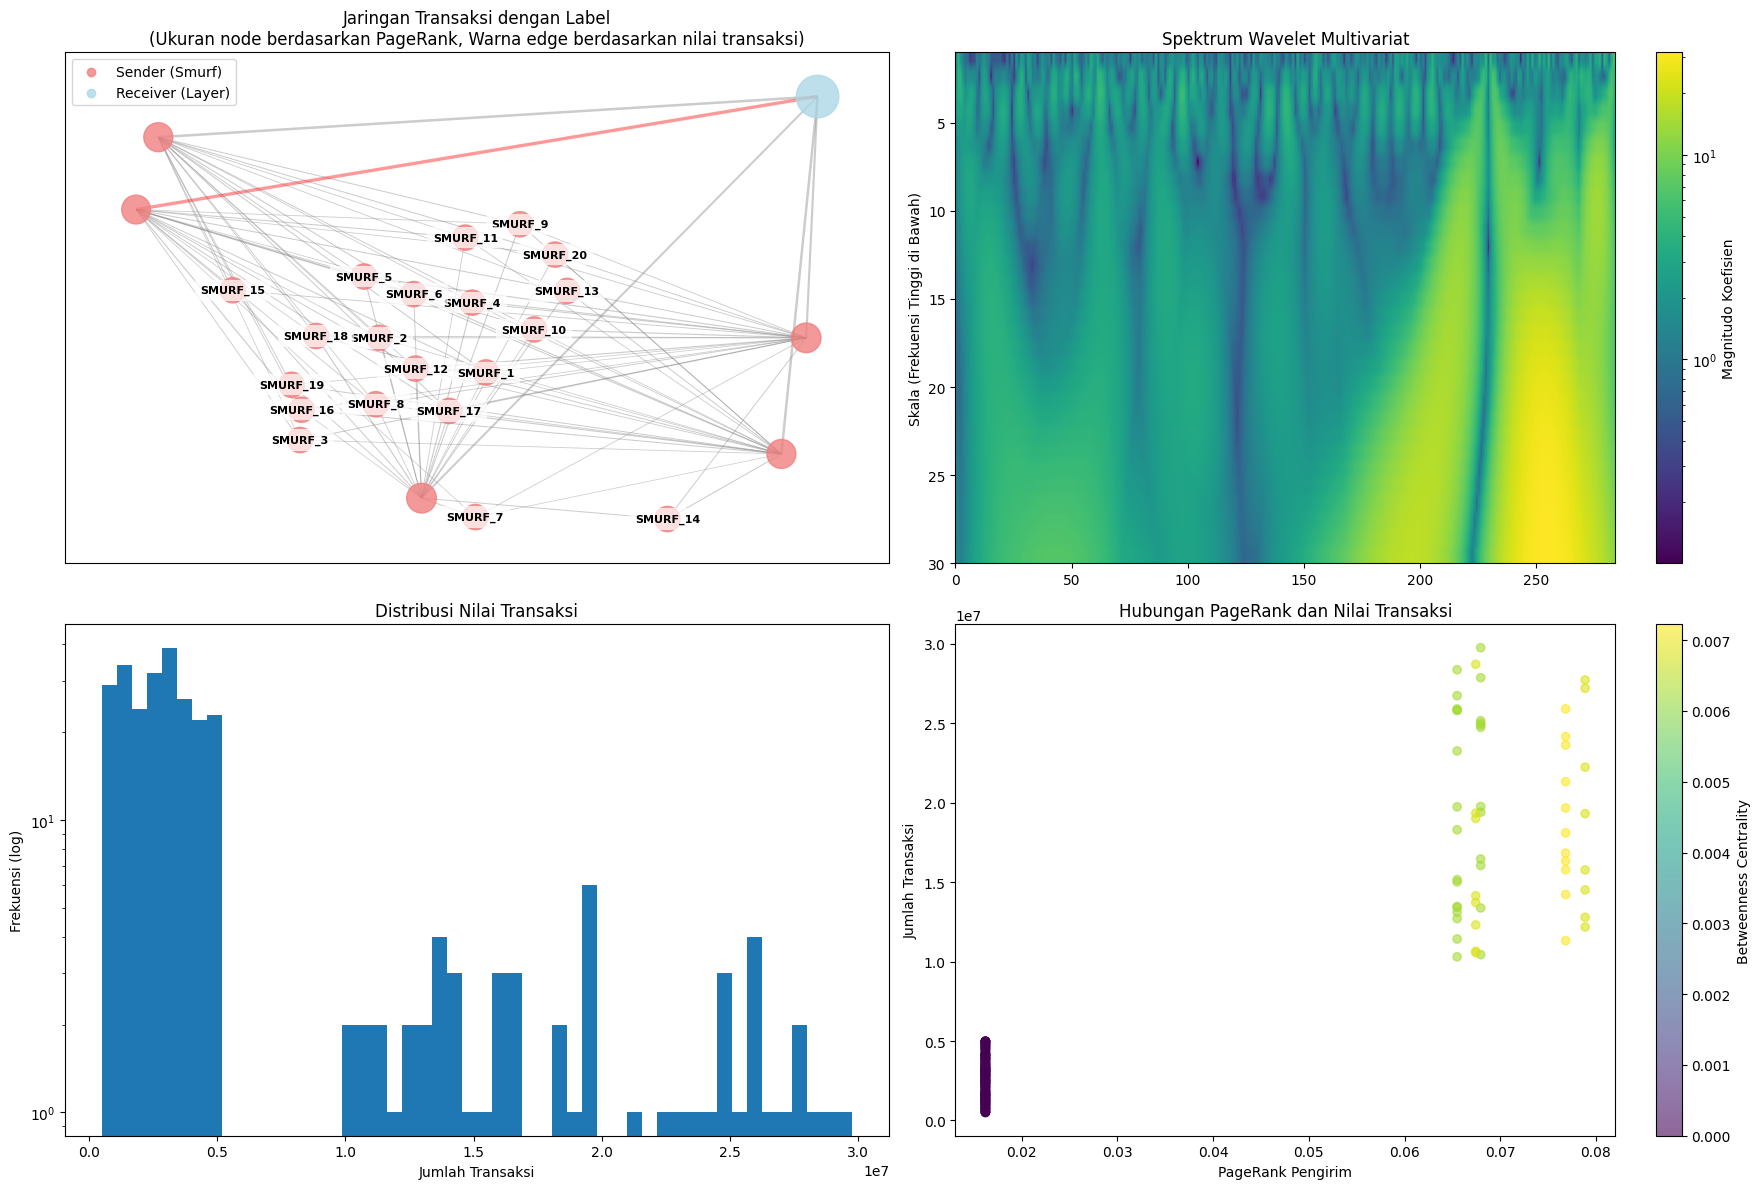


Top 10 Transaksi Paling Mencurigakan:
     timestamp   sender    receiver       amount  anomaly_score
255 2025-05-18  LAYER_1  FINAL_DEST  28705978.92       0.014070
232 2025-05-11  LAYER_4  FINAL_DEST  11312408.25       0.011973
229 2025-05-02  LAYER_4  FINAL_DEST  25899217.24       0.011229
249 2025-05-21  LAYER_3  FINAL_DEST  10437372.28       0.010955
265 2025-05-19  LAYER_2  FINAL_DEST  27721941.69       0.009607
283 2025-05-27  LAYER_5  FINAL_DEST  28363756.53       0.009553
263 2025-05-15  LAYER_2  FINAL_DEST  27195145.67       0.009029
248 2025-05-20  LAYER_3  FINAL_DEST  29750423.07       0.008941
230 2025-05-09  LAYER_4  FINAL_DEST  24162688.70       0.008467
278 2025-05-19  LAYER_5  FINAL_DEST  10299248.79       0.008221


In [9]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import cwt, ricker
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Feature Engineering Kompleks
def advanced_feature_engineering(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    # Statistik per sender
    sender_stats = df.groupby('sender').agg({
        'amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
        'hour': ['mean', 'std'],
        'receiver': pd.Series.nunique
    }).reset_index()
    sender_stats.columns = ['sender', 'sender_tx_count', 'sender_total', 'sender_avg', 
                            'sender_std', 'sender_min', 'sender_max', 'sender_hour_mean',
                            'sender_hour_std', 'unique_receivers']
    
    # Statistik per receiver
    receiver_stats = df.groupby('receiver').agg({
        'amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
        'hour': ['mean', 'std'],
        'sender': pd.Series.nunique
    }).reset_index()
    receiver_stats.columns = ['receiver', 'receiver_tx_count', 'receiver_total', 
                              'receiver_avg', 'receiver_std', 'receiver_min', 
                              'receiver_max', 'receiver_hour_mean', 'receiver_hour_std',
                              'unique_senders']
    
    df = pd.merge(df, sender_stats, on='sender')
    df = pd.merge(df, receiver_stats, on='receiver')
    
    df['sender_receiver_ratio'] = df['sender_tx_count'] / (df['receiver_tx_count'] + 1)
    df['amount_deviation'] = (df['amount'] - df['sender_avg']) / (df['sender_std'] + 1e-6)
    df['time_diff'] = df.groupby('sender')['timestamp'].diff().dt.total_seconds()
    df['amount_diff'] = df.groupby('sender')['amount'].diff()
    
    return df

# 2. Graph Analysis
def build_transaction_graph(df):
    G = nx.DiGraph()
    
    for _, row in df.iterrows():
        G.add_node(row['sender'], type='sender')
        G.add_node(row['receiver'], type='receiver')
        G.add_edge(row['sender'], row['receiver'], amount=row['amount'], timestamp=row['timestamp'])
    
    betweenness = nx.betweenness_centrality(G)
    pagerank = nx.pagerank(G, weight='amount')
    degree_centrality = nx.degree_centrality(G)
    
    df['sender_betweenness'] = df['sender'].map(betweenness)
    df['receiver_betweenness'] = df['receiver'].map(betweenness)
    df['sender_pagerank'] = df['sender'].map(pagerank)
    df['receiver_pagerank'] = df['receiver'].map(pagerank)
    df['sender_degree'] = df['sender'].map(degree_centrality)
    df['receiver_degree'] = df['receiver'].map(degree_centrality)
    
    return G, df

# 3. Wavelet Analysis
def multivariate_wavelet_analysis(df, n_components=3):
    features = ['amount', 'sender_tx_count', 'receiver_tx_count', 
                'sender_avg', 'receiver_avg', 'time_diff', 'amount_diff',
                'sender_betweenness', 'receiver_betweenness']
    
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features].fillna(0))
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    widths = np.arange(1, 31)
    wavelet_coeffs = [cwt(X_pca[:, i], ricker, widths) for i in range(n_components)]
    
    return wavelet_coeffs, pca, widths

# 4. Visualization - Updated Version with Enhanced Graph Labels
def visualize_results(df, G, wavelet_coeffs, widths):
    plt.figure(figsize=(18, 12))
    
    # 1. Enhanced Network Graph Visualization
    plt.subplot(2, 2, 1)
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Prepare node colors and sizes based on type and centrality
    node_colors = []
    node_sizes = []
    labels = {}
    
    for node in G.nodes():
        if G.nodes[node]['type'] == 'sender':
            node_colors.append('lightcoral')
            # Scale size by pagerank
            node_sizes.append(300 + 2000 * df[df['sender'] == node]['sender_pagerank'].mean())
            labels[node] = node if 'SMURF' in node else ''
        else:
            node_colors.append('lightblue')
            # Scale size by pagerank
            node_sizes.append(300 + 2000 * df[df['receiver'] == node]['receiver_pagerank'].mean())
            labels[node] = node if 'LAYER' in node else ''
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
    
    # Highlight edges with large amounts
    edge_colors = []
    edge_widths = []
    for u, v in G.edges():
        edge_data = G.get_edge_data(u, v)
        edge_colors.append('red' if edge_data['amount'] > df['amount'].quantile(0.95) else 'gray')
        edge_widths.append(0.5 + edge_data['amount'] / df['amount'].max() * 2)
    
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.4, arrows=False)
    
    # Draw labels with better formatting
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold',
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Add legend
    plt.scatter([], [], c='lightcoral', label='Sender (Smurf)', alpha=0.8)
    plt.scatter([], [], c='lightblue', label='Receiver (Layer)', alpha=0.8)
    plt.legend(scatterpoints=1, frameon=True, loc='best')
    
    plt.title('Jaringan Transaksi dengan Label\n(Ukuran node berdasarkan PageRank, Warna edge berdasarkan nilai transaksi)')
    
    # 2. Wavelet Spectrum (unchanged)
    plt.subplot(2, 2, 2)
    combined_coeffs = np.sum([np.abs(c) for c in wavelet_coeffs], axis=0)
    plt.imshow(combined_coeffs, extent=[0, len(df), widths[-1], widths[0]], 
               cmap='viridis', aspect='auto', norm=LogNorm())
    plt.colorbar(label='Magnitudo Koefisien')
    plt.title('Spektrum Wavelet Multivariat')
    plt.ylabel('Skala (Frekuensi Tinggi di Bawah)')
    
    # 3. Histogram Amount (unchanged)
    plt.subplot(2, 2, 3)
    plt.hist(df['amount'], bins=50, log=True)
    plt.xlabel('Jumlah Transaksi')
    plt.ylabel('Frekuensi (log)')
    plt.title('Distribusi Nilai Transaksi')
    
    # 4. Scatter Pagerank vs Amount (unchanged)
    plt.subplot(2, 2, 4)
    plt.scatter(df['sender_pagerank'], df['amount'], 
                c=df['sender_betweenness'], alpha=0.6, cmap='viridis')
    plt.colorbar(label='Betweenness Centrality')
    plt.xlabel('PageRank Pengirim')
    plt.ylabel('Jumlah Transaksi')
    plt.title('Hubungan PageRank dan Nilai Transaksi')
    
    plt.tight_layout()
    plt.show()
    
# 5. Main Pipeline
def main():
    # Load data simulasi skenario 3
    df = pd.read_csv("smurfing_layering.csv")  # ganti path jika perlu
    df.head()
    df = advanced_feature_engineering(df)
    G, df = build_transaction_graph(df)
    wavelet_coeffs, pca, widths = multivariate_wavelet_analysis(df)
    visualize_results(df, G, wavelet_coeffs, widths)
    
    # Simpan hasil
    df.to_csv("enhanced_smurfing_data.csv", index=False)
    
    # Deteksi anomali sederhana
    df['anomaly_score'] = df['sender_betweenness'] * df['amount_deviation'].abs()
    top_anomalies = df.nlargest(10, 'anomaly_score')
    print("\nTop 10 Transaksi Paling Mencurigakan:")
    print(top_anomalies[['timestamp', 'sender', 'receiver', 'amount', 'anomaly_score']])

# Eksekusi
if __name__ == "__main__":
    main()


Data berhasil dimuat. Jumlah record: 284
Feature engineering berhasil dilakukan.
Analisis graph berhasil. Jumlah node: 26 Jumlah edge: 99
Analisis wavelet berhasil.


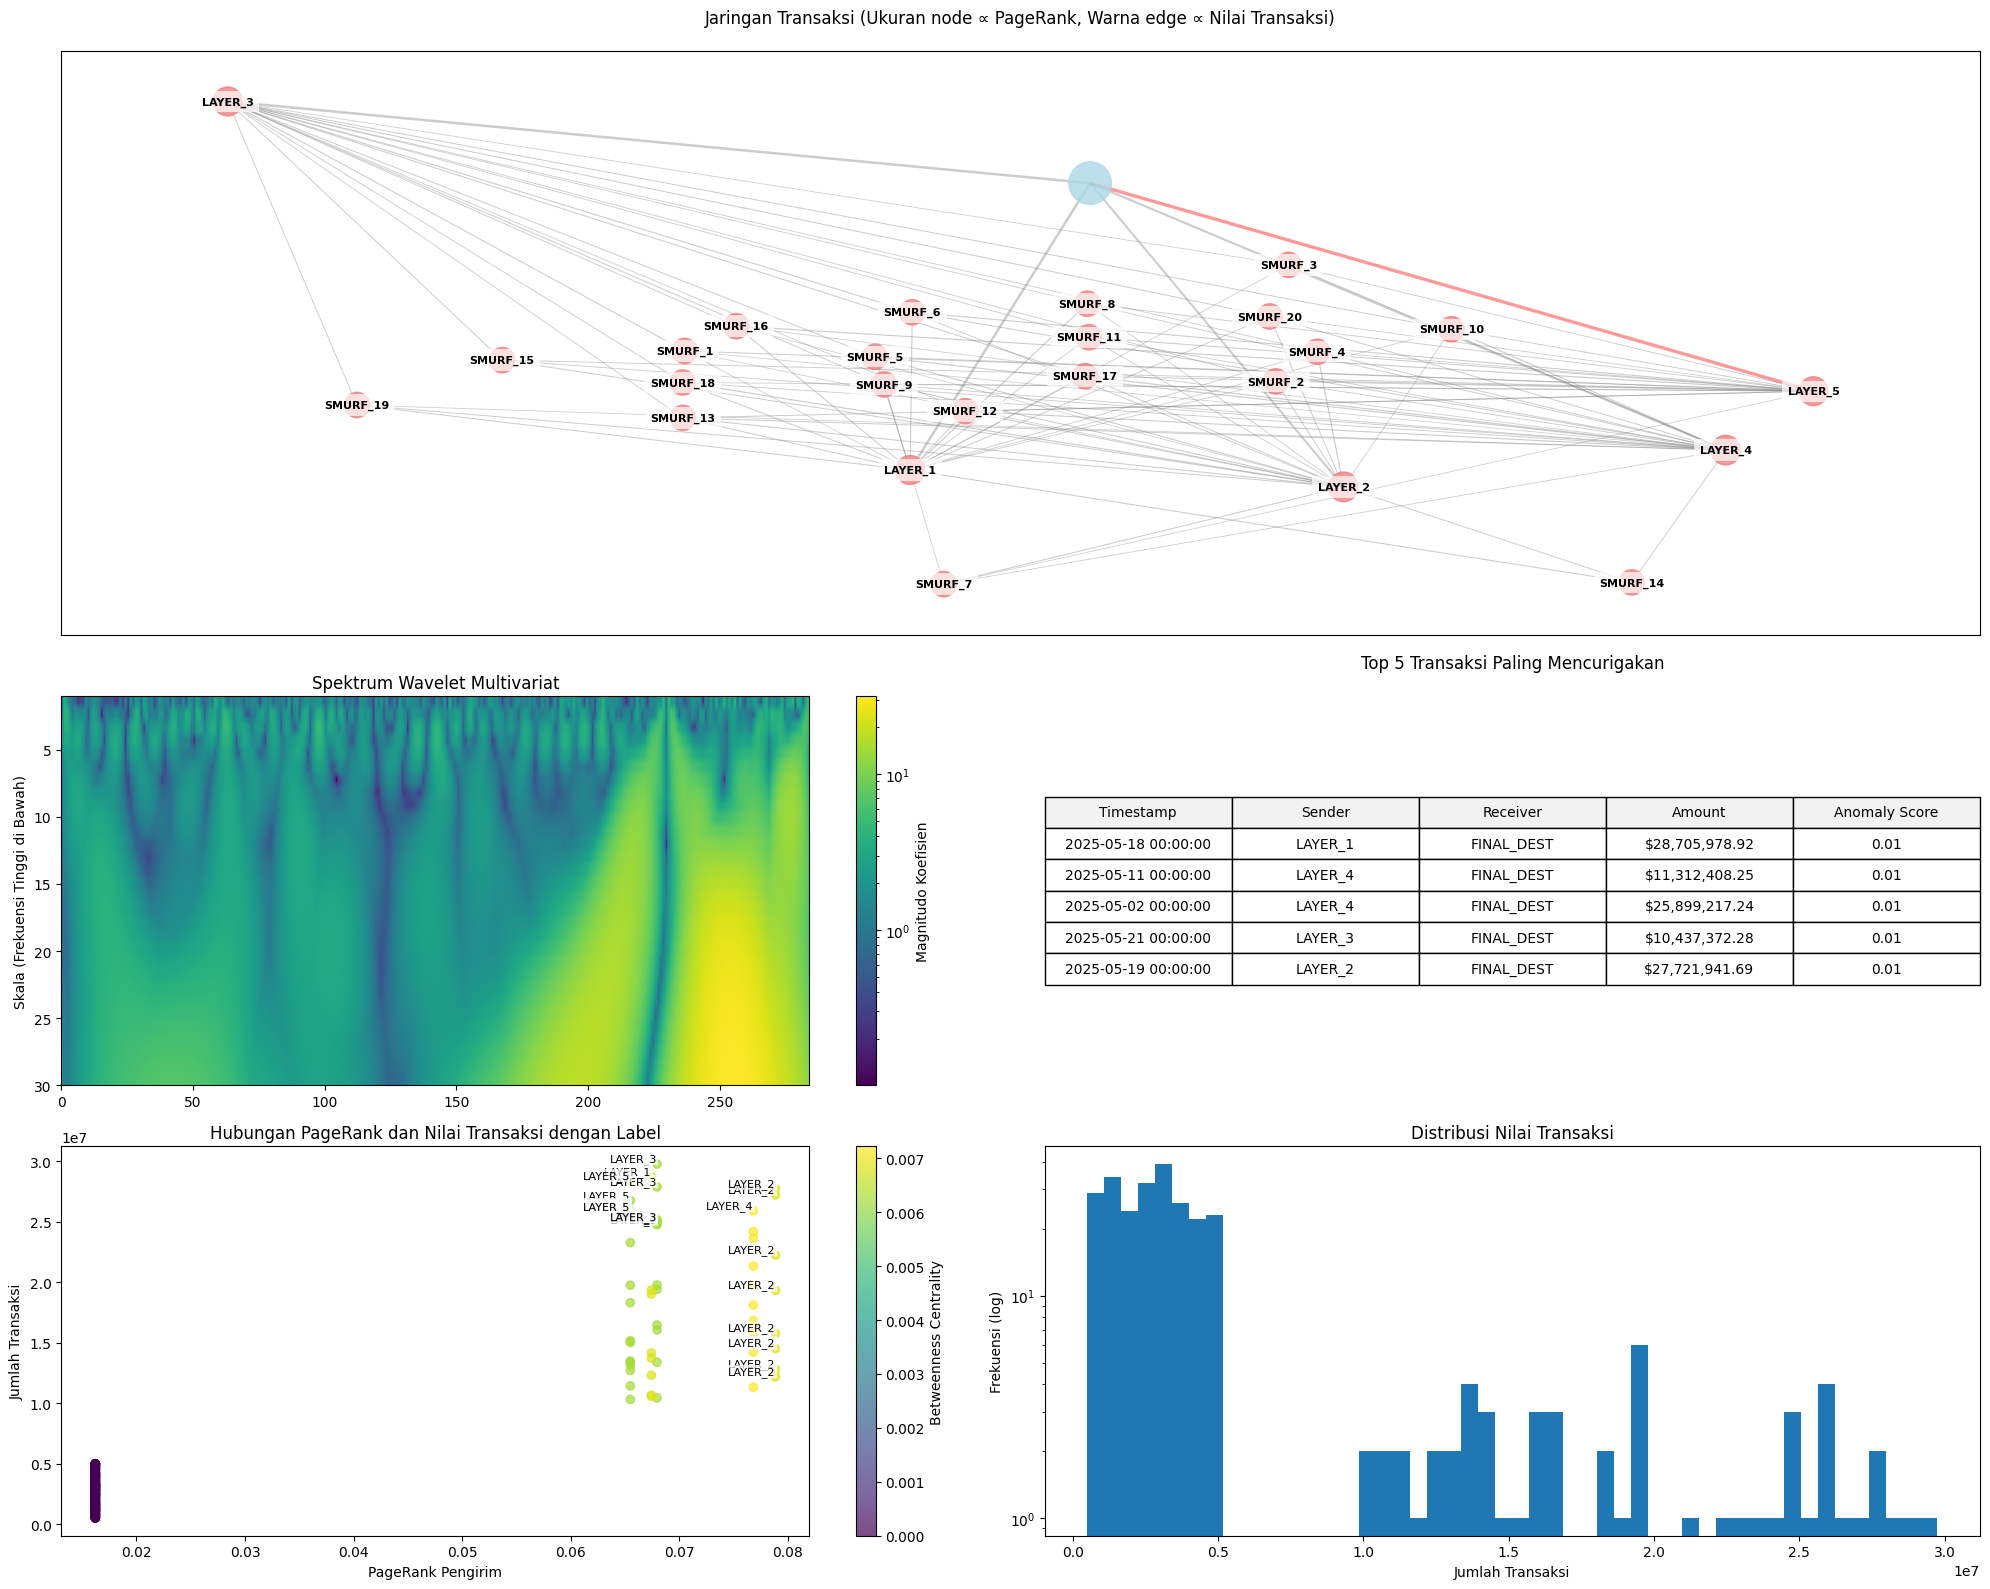

Visualisasi berhasil dibuat.
Data hasil analisis disimpan ke 'enhanced_smurfing_data.csv'

Top 10 Transaksi Paling Mencurigakan:
 timestamp  sender   receiver      amount  anomaly_score
2025-05-18 LAYER_1 FINAL_DEST 28705978.92       0.014070
2025-05-11 LAYER_4 FINAL_DEST 11312408.25       0.011973
2025-05-02 LAYER_4 FINAL_DEST 25899217.24       0.011229
2025-05-21 LAYER_3 FINAL_DEST 10437372.28       0.010955
2025-05-19 LAYER_2 FINAL_DEST 27721941.69       0.009607
2025-05-27 LAYER_5 FINAL_DEST 28363756.53       0.009553
2025-05-15 LAYER_2 FINAL_DEST 27195145.67       0.009029
2025-05-20 LAYER_3 FINAL_DEST 29750423.07       0.008941
2025-05-09 LAYER_4 FINAL_DEST 24162688.70       0.008467
2025-05-19 LAYER_5 FINAL_DEST 10299248.79       0.008221


In [16]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import cwt, ricker
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec
import seaborn as sns

# 1. Feature Engineering Kompleks
def advanced_feature_engineering(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    # Statistik pengirim
    sender_stats = df.groupby('sender').agg({
        'amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
        'hour': ['mean', 'std'],
        'receiver': pd.Series.nunique
    }).reset_index()
    sender_stats.columns = ['sender', 'sender_tx_count', 'sender_total', 'sender_avg', 
                          'sender_std', 'sender_min', 'sender_max', 'sender_hour_mean',
                          'sender_hour_std', 'unique_receivers']
    
    # Statistik penerima
    receiver_stats = df.groupby('receiver').agg({
        'amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
        'hour': ['mean', 'std'],
        'sender': pd.Series.nunique
    }).reset_index()
    receiver_stats.columns = ['receiver', 'receiver_tx_count', 'receiver_total', 
                            'receiver_avg', 'receiver_std', 'receiver_min', 
                            'receiver_max', 'receiver_hour_mean', 'receiver_hour_std',
                            'unique_senders']
    
    # Gabungkan fitur
    df = pd.merge(df, sender_stats, on='sender')
    df = pd.merge(df, receiver_stats, on='receiver')
    
    # Hitung fitur tambahan
    df['sender_receiver_ratio'] = df['sender_tx_count'] / (df['receiver_tx_count'] + 1)
    df['amount_deviation'] = (df['amount'] - df['sender_avg']) / (df['sender_std'] + 1e-6)
    df['time_diff'] = df.groupby('sender')['timestamp'].diff().dt.total_seconds()
    df['amount_diff'] = df.groupby('sender')['amount'].diff()
    
    return df

# 2. Graph Analysis
def build_transaction_graph(df):
    G = nx.DiGraph()
    
    # Tambahkan node dan edge
    for _, row in df.iterrows():
        G.add_node(row['sender'], type='sender')
        G.add_node(row['receiver'], type='receiver')
        G.add_edge(row['sender'], row['receiver'], amount=row['amount'], timestamp=row['timestamp'])
    
    # Hitung metrik jaringan
    betweenness = nx.betweenness_centrality(G)
    pagerank = nx.pagerank(G, weight='amount')
    degree_centrality = nx.degree_centrality(G)
    
    # Tambahkan metrik ke dataframe
    df['sender_betweenness'] = df['sender'].map(betweenness)
    df['receiver_betweenness'] = df['receiver'].map(betweenness)
    df['sender_pagerank'] = df['sender'].map(pagerank)
    df['receiver_pagerank'] = df['receiver'].map(pagerank)
    df['sender_degree'] = df['sender'].map(degree_centrality)
    df['receiver_degree'] = df['receiver'].map(degree_centrality)
    
    # Hitung anomaly score setelah mendapatkan betweenness
    df['anomaly_score'] = df['sender_betweenness'] * df['amount_deviation'].abs()
    
    return G, df

# 3. Wavelet Analysis
def multivariate_wavelet_analysis(df, n_components=3):
    features = ['amount', 'sender_tx_count', 'receiver_tx_count', 
               'sender_avg', 'receiver_avg', 'time_diff', 'amount_diff',
               'sender_betweenness', 'receiver_betweenness']
    
    # Standarisasi data
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features].fillna(0))
    
    # Reduksi dimensi dengan PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Analisis wavelet
    widths = np.arange(1, 31)
    wavelet_coeffs = []
    for i in range(n_components):
        coeffs = cwt(X_pca[:, i], ricker, widths)
        wavelet_coeffs.append(coeffs)
    
    return wavelet_coeffs, pca, widths

# 4. Enhanced Visualization with Detailed Scatter Plot
def visualize_results(df, G, wavelet_coeffs, widths):
    plt.figure(figsize=(20, 16))
    gs = GridSpec(3, 2, height_ratios=[1.5, 1, 1])
    
    # 1. Network Graph
    ax1 = plt.subplot(gs[0, :])
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Warna dan ukuran node
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        if G.nodes[node]['type'] == 'sender':
            node_colors.append('lightcoral')
            # Ukuran berdasarkan pagerank sender
            sender_pagerank = df.loc[df['sender'] == node, 'sender_pagerank'].mean()
            node_sizes.append(300 + 2000 * (sender_pagerank if not np.isnan(sender_pagerank) else 0))
        else:
            node_colors.append('lightblue')
            # Ukuran berdasarkan pagerank receiver
            receiver_pagerank = df.loc[df['receiver'] == node, 'receiver_pagerank'].mean()
            node_sizes.append(300 + 2000 * (receiver_pagerank if not np.isnan(receiver_pagerank) else 0))
    
    # Gambar node dan edge
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8, ax=ax1)
    
    # Warna dan ketebalan edge
    edge_colors = []
    edge_widths = []
    for u, v in G.edges():
        edge_data = G.get_edge_data(u, v)
        edge_colors.append('red' if edge_data['amount'] > df['amount'].quantile(0.95) else 'gray')
        edge_widths.append(0.5 + edge_data['amount'] / df['amount'].max() * 2)
    
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.4, arrows=False, ax=ax1)
    
    # Label hanya untuk node penting
    labels = {}
    for node in G.nodes():
        if ('SMURF' in node or 'LAYER' in node) and (G.nodes[node]['type'] == 'sender' or 
           (df['receiver'] == node).any() and df.loc[df['receiver'] == node, 'receiver_pagerank'].max() > 0.1):
            labels[node] = node
        else:
            labels[node] = ''
    
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold', 
                          bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'), ax=ax1)
    
    ax1.set_title('Jaringan Transaksi (Ukuran node ∝ PageRank, Warna edge ∝ Nilai Transaksi)', pad=20)
    
    # 2. Wavelet Spectrum
    ax2 = plt.subplot(gs[1, 0])
    combined_coeffs = np.sum([np.abs(c) for c in wavelet_coeffs], axis=0)
    im = ax2.imshow(combined_coeffs, extent=[0, len(df), widths[-1], widths[0]], 
                   cmap='viridis', aspect='auto', norm=LogNorm())
    plt.colorbar(im, ax=ax2, label='Magnitudo Koefisien')
    ax2.set_title('Spektrum Wavelet Multivariat')
    ax2.set_ylabel('Skala (Frekuensi Tinggi di Bawah)')
    
    # 3. Top Anomalies Table
    ax3 = plt.subplot(gs[1, 1])
    ax3.axis('off')
    top_anomalies = df.nlargest(5, 'anomaly_score')[['timestamp', 'sender', 'receiver', 'amount', 'anomaly_score']]
    top_anomalies['amount'] = top_anomalies['amount'].apply(lambda x: f"${x:,.2f}")
    top_anomalies['anomaly_score'] = top_anomalies['anomaly_score'].round(2)
    
    table = ax3.table(cellText=top_anomalies.values,
                     colLabels=['Timestamp', 'Sender', 'Receiver', 'Amount', 'Anomaly Score'],
                     loc='center',
                     cellLoc='center',
                     colColours=['#f2f2f2']*5)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    ax3.set_title('Top 5 Transaksi Paling Mencurigakan', pad=20)
    
    # 4. Enhanced Scatter Plot with Labels
    ax4 = plt.subplot(gs[2, 0])
    scatter = ax4.scatter(df['sender_pagerank'], df['amount'], 
                         c=df['sender_betweenness'], alpha=0.7, cmap='viridis')
    plt.colorbar(scatter, ax=ax4, label='Betweenness Centrality')
    ax4.set_xlabel('PageRank Pengirim')
    ax4.set_ylabel('Jumlah Transaksi')
    ax4.set_title('Hubungan PageRank dan Nilai Transaksi dengan Label')
    
    # Tambahkan label untuk akun penting
    threshold_amount = df['amount'].quantile(0.95)
    threshold_pagerank = df['sender_pagerank'].quantile(0.95)
    
    for i, row in df.iterrows():
        if row['amount'] > threshold_amount or row['sender_pagerank'] > threshold_pagerank:
            ax4.text(row['sender_pagerank'], row['amount'], row['sender'], 
                    fontsize=8, ha='right', va='bottom',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    # 5. Histogram
    ax5 = plt.subplot(gs[2, 1])
    ax5.hist(df['amount'], bins=50, log=True)
    ax5.set_xlabel('Jumlah Transaksi')
    ax5.set_ylabel('Frekuensi (log)')
    ax5.set_title('Distribusi Nilai Transaksi')
    
    plt.tight_layout()
    plt.show()

# 5. Main Pipeline
def main():
    # Load data
    try:
        df = pd.read_csv("smurfing_layering.csv")
        print("Data berhasil dimuat. Jumlah record:", len(df))
    except FileNotFoundError:
        print("Error: File 'smurfing_layering.csv' tidak ditemukan.")
        return
    except Exception as e:
        print(f"Error saat memuat data: {str(e)}")
        return
    
    # Feature Engineering
    try:
        df = advanced_feature_engineering(df)
        print("Feature engineering berhasil dilakukan.")
    except Exception as e:
        print(f"Error dalam feature engineering: {str(e)}")
        return
    
    # Graph Analysis
    try:
        G, df = build_transaction_graph(df)
        print("Analisis graph berhasil. Jumlah node:", G.number_of_nodes(), 
              "Jumlah edge:", G.number_of_edges())
    except Exception as e:
        print(f"Error dalam analisis graph: {str(e)}")
        return
    
    # Wavelet Analysis
    try:
        wavelet_coeffs, pca, widths = multivariate_wavelet_analysis(df)
        print("Analisis wavelet berhasil.")
    except Exception as e:
        print(f"Error dalam analisis wavelet: {str(e)}")
        return
    
    # Visualization
    try:
        visualize_results(df, G, wavelet_coeffs, widths)
        print("Visualisasi berhasil dibuat.")
    except Exception as e:
        print(f"Error dalam visualisasi: {str(e)}")
        return
    
    # Save results
    try:
        df.to_csv("enhanced_smurfing_data.csv", index=False)
        print("Data hasil analisis disimpan ke 'enhanced_smurfing_data.csv'")
    except Exception as e:
        print(f"Error saat menyimpan hasil: {str(e)}")
    
    # Print top anomalies
    try:
        top_anomalies = df.nlargest(10, 'anomaly_score')
        print("\nTop 10 Transaksi Paling Mencurigakan:")
        print(top_anomalies[['timestamp', 'sender', 'receiver', 'amount', 'anomaly_score']].to_string(index=False))
    except Exception as e:
        print(f"Error saat menampilkan hasil anomaly: {str(e)}")

if __name__ == "__main__":
    main()